In [2]:
!pip install sagemaker ipywidgets --upgrade --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
awscli 1.27.111 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.


In [3]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sagemaker
from sagemaker import image_uris

from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.xgboost.model import XGBoostModel
from sagemaker.serializers import CSVSerializer


In [35]:
s3=boto3.resource('s3')

In [36]:
bucket_name='fractionatordatalstm'
try:
    s3.create_bucket(Bucket=bucket_name)
    print("S3 bucket {} was created".format(bucket_name))
except Exception as e:
    print("S3 error: ",e)

S3 bucket fractionatordatalstm was created


In [37]:
# Print out bucket names
for bucket in s3.buckets.all():
    print(bucket.name)

fractionatordata
fractionatordatalstm
sagemaker-automated-execution-860648665930-us-east-1
sagemaker-studio-860648665930-gns5xa693ri
sagemaker-us-east-1-860648665930


In [42]:
s3 = boto3.client("s3")

s3.download_file(
    Bucket="fractionatordatalstm",Key="control_furnace/test/test.csv" ,Filename="test.csv"
)
# Key="" s3://fractionatordatalstm/control_furnace/test/

In [43]:
s3 = boto3.client("s3")

s3.download_file(
    Bucket="fractionatordatalstm",Key="control_furnace/train/train.csv" ,Filename="train.csv"
)
# Key="" s3://fractionatordatalstm/control_furnace/test/

In [27]:

df.head()

,Time,AI_top,AI_middle,AI_bottom,Furnace,FIC-2101_PV_TOP_PRODUCT_MBBL/D,FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,Feed,FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2001_OP_TOP_REFLUX_OUTPUT_%,FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D,FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%,FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D,FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D,FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%,Reflux_top,QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H,TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF
0,2009-10-01 08:14:00,2.00000,3.00000,4.00000,8.50000,2.10000,1.70000,5.02153,2.5,41.5425,2.64333,1.5,39.6248,1.55033,8.0,27.0211,8.06381,2.00000,200.0
1,2009-10-01 08:15:00,2.00360,3.00954,3.99831,8.50735,2.09686,1.71730,4.98768,2.5,40.7619,2.51377,1.5,32.2511,1.43952,8.0,30.9622,8.02407,1.99772,200.0
2,2009-10-01 08:16:00,2.00870,2.99518,3.97746,8.50977,2.09280,1.72500,4.93990,2.5,39.5543,2.39550,1.5,36.5874,1.55065,8.0,33.4288,7.92434,1.99552,200.0
3,2009-10-01 08:17:00,2.00385,3.01356,3.97262,8.50838,2.08587,1.71878,4.93333,2.5,39.3031,2.32773,1.5,37.0797,1.50101,8.0,26.2273,8.03058,1.99483,200.0
4,2009-10-01 08:18:00,1.99852,3.02963,3.98841,8.50365,2.08028,1.71360,4.96880,2.5,40.1886,2.50900,1.5,33.2056,1.48210,8.0,29.6134,8.06181,1.99465,200.0


In [5]:
df=pd.read_csv('Fractionator.csv')

In [6]:
df['Time']=pd.to_datetime(df['Time'])

In [7]:
df=df[(np.abs(stats.zscore(df["AI_2020_OVERHEAD_C5'S_MOL"])) < 3)]

In [8]:
df.rename(columns = {"AI_2020_OVERHEAD_C5'S_MOL":"AI_top","AI_2021_MIDDLE_C7'S_MOL":"AI_middle","AI_2022_BOTTOM_C3'S_MOL":"AI_bottom",
                          'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH':'Furnace' ,'FIC_2004_PV_TOP_REFLUX_MBBL/D':'Reflux_top',
                    'FI-2005_PV_FEED_FLOW_MBBL/D':'Feed'
 }, inplace = True)

In [17]:
df_Reg=df[['Furnace','AI_top','AI_middle','AI_bottom',]]

In [18]:
df_Reg.head()

,Furnace,AI_top,AI_middle,AI_bottom
0,8.50000,2.00000,3.00000,4.00000
1,8.50735,2.00360,3.00954,3.99831
2,8.50977,2.00870,2.99518,3.97746
3,8.50838,2.00385,3.01356,3.97262
4,8.50365,1.99852,3.02963,3.98841


In [19]:
df_Reg.describe()

,Furnace,AI_top,AI_middle,AI_bottom
count,5729.000000,5729.000000,5729.000000,5729.000000
mean,9.041685,2.129367,3.352078,3.965614
std,0.535607,0.439436,0.233710,0.360089
min,7.999970,0.840555,2.820780,3.067540
25%,8.568900,1.831880,3.174090,3.773500
50%,9.010910,2.120570,3.306720,4.013200
75%,9.415850,2.439360,3.520840,4.213050
max,10.611500,3.297840,3.930950,4.856360


In [20]:
df_Reg.isnull().sum()

Furnace      0
AI_top       0
AI_middle    0
AI_bottom    0
dtype: int64

In [21]:
df_Reg.corr()

,Furnace,AI_top,AI_middle,AI_bottom
Furnace,1.000000,0.407673,0.171360,-0.687598
AI_top,0.407673,1.000000,0.538482,-0.553021
AI_middle,0.171360,0.538482,1.000000,-0.457908
AI_bottom,-0.687598,-0.553021,-0.457908,1.000000


In [22]:
X=df_Reg.iloc[:,1:].values
y=df_Reg.iloc[:,0].values

In [24]:
y[0]

8.5

In [16]:
df_np=df_Reg.to_numpy()
df_np.shape

(5729, 4)

In [17]:
target=df_np[:,0]
feature=df_np[:,1:]
target.shape,feature.shape

((5729,), (5729, 3))

In [63]:
train_data[0]

0       2.63081
1       2.36694
2       1.51664
3       2.06310
4       1.67002
         ...   
3833    2.78767
3834    2.41280
3835    2.57112
3836    2.44902
3837    2.21223
Name: 0, Length: 3838, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [28]:
y_train[0]

9.63946

In [29]:
train_data = np.concatenate((y_train.reshape(-1,1), X_train), axis=1)
test_data = np.concatenate((y_test.reshape(-1,1), X_test), axis=1)
val_data = np.concatenate((y_val.reshape(-1,1), X_val), axis=1)

In [31]:
train_data[0]

array([9.63946, 2.63081, 3.44818, 3.23914])

In [32]:
train_data=pd.DataFrame(train_data, index=None,)
test_data=pd.DataFrame(test_data, index=None,)
val_data=pd.DataFrame(val_data, index=None, )

In [38]:
import os
prefix="control_furnace"
train_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'train','train.csv')
val_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'val','val.csv')
test_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'test','test.csv')
print(train_csv_path)
print(val_csv_path)
print(test_csv_path)


s3://fractionatordatalstm/control_furnace/train/train.csv
s3://fractionatordatalstm/control_furnace/val/val.csv
s3://fractionatordatalstm/control_furnace/test/test.csv


In [39]:
train_data.to_csv(train_csv_path,index=False,header=False)
val_data.to_csv(val_csv_path,index=False,header=False)
test_data.to_csv(test_csv_path,index=False,header=False)


In [40]:
output_path="s3://{}/{}/{}/".format(bucket_name,prefix,'output')
print(output_path)

s3://fractionatordatalstm/control_furnace/output/


In [41]:
content_type="csv"
train_input=TrainingInput("s3://{}/{}/{}/".format(bucket_name,prefix,'train',content_type=content_type))
val_input=TrainingInput("s3://{}/{}/{}/".format(bucket_name,prefix,'val',content_type=content_type))
test_input=TrainingInput("s3://{}/{}/{}/".format(bucket_name,prefix,'test',content_type=content_type))

In [55]:
test_df=pd.read_csv("test.csv")
train_df=pd.read_csv("train.csv")

In [56]:
test_df.head()

,9.23188,2.0362,3.38643,3.89379
0,8.83145,1.87453,3.45013,3.90349
1,9.11514,2.09413,3.68392,3.99708
2,8.61245,2.47046,3.66139,4.21000
3,8.20437,2.35434,3.36145,3.96043
4,8.48909,1.77156,3.12398,4.43154


In [46]:
train_df.head()

,9.63946,2.63081,3.44818,3.23914
0,9.91781,2.36694,3.36823,3.80285
1,9.04111,1.51664,3.13586,3.97599
2,9.87153,2.06310,3.04215,3.79857
3,9.68077,1.67002,3.07148,4.19419
4,8.61546,2.46116,3.86426,3.77654


In [47]:
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# Load data
data = df_np

# Define input and output sequences
X = df_np[:, :-1]
y = df_np[:, -1]

# Split data into training and validation sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]

# Define PyTorch model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMRegressor(input_size=3, hidden_size=64, num_layers=1, output_size=1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Define PyTorch data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



TypeError: 'int' object is not callable

In [ ]:
# Train PyTorch model
num_epochs = 50
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        val_loss = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels)
        val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}: train loss={loss.item():.4f}, val loss={val_loss.item():.4f}')

# Save model
torch.save(model.state_dict(), 'lstm_regression_model.pt')

In [48]:
#Here, we use the execution role associated with the current notebook instance
#as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/', 'validation/' (optional), and a json-format file named 'categorical_index.json' (optional). Each sub-directory contains a 'data.csv' file (The Abalone dataset used in this example has been prepared and saved in training_dataset_s3_path shown below).

The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data.

The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).

If the predictors include categorical feature(s), a json-format file named 'categorical_index.json' should be included in the input directory to indicate the column index(es) of the categorical features. Within the json-format file, it should have a python directory where the key is a string of 'cat_index_list' and the value is a list of unique integer(s). Each integer in the list indicates the column index of categorical features in the 'data.csv'. The range of each integer should be more than 0 (index 0 indicates the target) and less than the total number of columns. If the data set does not contain any categorical feature, the TabTransformer algorithm is equivalently a multi-layer perceptron (MLP).

The target column must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers started from zero.

All the categorical features do not need to be encoded as non-negative integers and can be kept as their original formats.

Note. The number of json-format files should be no more than 1 in the input directory.

Citations:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

2.1. Retrieve Training Artifacts

In [49]:
from sagemaker import image_uris
from sagemaker import model_uris 
from sagemaker import script_uris

train_model_id, train_model_version, train_scope = (
    "pytorch-tabtransformerregression-model",
    "*",
    "training",
)

training_instance_type = "ml.m5.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

2.2. Set Training Parameters

In [50]:
# Sample training data is available in this bucket
#training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
#training_data_prefix = "training-datasets/tabular_regress/"

training_dataset_s3_path = train_csv_path
#f"s3://{training_data_bucket}/{training_data_prefix}"

#output_bucket = sess.default_bucket()
#output_prefix = "jumpstart-example-tabular-training"

s3_output_location = output_path
#f"s3://{output_bucket}/{output_prefix}/output"

In [51]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["n_epochs"] = "80"
print(hyperparameters)

{'n_epochs': '80', 'patience': '15', 'learning_rate': '0.001', 'batch_size': '128', 'input_dim': '32', 'n_blocks': '4', 'attn_dropout': '0.2', 'mlp_dropout': '0.1', 'frac_shared_embed': '0.25'}


2.3. Train with Automatic Model Tuning


In [52]:
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, HyperparameterTuner

use_amt = True

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "batch_size": CategoricalParameter([128, 256, 512]),
    "attn_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
    "mlp_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
}

In [ ]:
2.4. Start Training
We start by creating the estimator object with all the required assets and then launch the training job.

In [53]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

if use_amt:

    tuner = HyperparameterTuner(
        tabular_estimator,
        "r2",
        hyperparameter_ranges,
        [{"Name": "r2", "Regex": "metrics={'r2': (\\S+)}"}],
        max_jobs=10,  # increase the max_jobs to achieve better performance from hyperparameter tuning
        max_parallel_jobs=2,
        objective_type="Maximize",
        base_tuning_job_name=training_job_name,
    )

    tuner.fit({"training": training_dataset_s3_path}, logs=True)

else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................!


In [ ]:
3. Deploy and Run Inference on the Trained Tabular Model
In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value to estimate the corresponding target value.

We start by retrieving the artifacts and deploy the tabular_estimator that we trained.

In [54]:
inference_instance_type = "ml.m5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)


2023-05-13 10:44:19 Starting - Found matching resource for reuse
2023-05-13 10:44:19 Downloading - Downloading input data
2023-05-13 10:44:19 Training - Training image download completed. Training in progress.
2023-05-13 10:44:19 Uploading - Uploading generated training model
2023-05-13 10:44:19 Completed - Resource reused by training job: jumpstart-pytorch-ta-230513-1037-008-4771d809
-----!

In [56]:
import boto3

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

bucket.download_file('/control_furnace/test/','test.csv')

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [55]:
import boto3
import botocore

BUCKET_NAME = bucket_name
# replace with your bucket name
KEY = '/control_furnace/test/' # replace with your object key

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'test .csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

The object does not exist.


In [ ]:
s3://fractionatordatalstm/control_furnace/test/test.csv

In [57]:
#Next, we download a hold-out Abalone test data from the S3 bucket for inference.

#jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
#test_data_prefix = "training-datasets/tabular_regress/test"
#test_data_file_name = "data.csv"

boto3.client("s3").download_file('s3://fractionatordatalstm/control_furnace/test/test.csv'
   
)
 #jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name


TypeError: download_file() missing 2 required positional arguments: 'Key' and 'Filename'

Next, we read the Abalone test data into pandas data frame, prepare the ground truth target and 
predicting features to send into the endpoint.

Below is the screenshot of the first 5 examples in the Abalone test set. 
All of the test examples with features from Feature_1 to Feature_8 are sent into the deployed model 
to get model predictions, to estimate the ground truth Target column.

In [53]:
df_test = pd.read_csv('test .csv')

In [57]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv('test.csv', header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(
    f"{bold}The first 5 observations of the test data: {unbold}")  
# Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 946 examples and 4 columns.

The first 5 observations of the test data: 


,Target,Feature_1,Feature_2,Feature_3
0,9.23188,2.03620,3.38643,3.89379
1,8.83145,1.87453,3.45013,3.90349
2,9.11514,2.09413,3.68392,3.99708
3,8.61245,2.47046,3.66139,4.21000
4,8.20437,2.35434,3.36145,3.96043


The following code queries the endpoint you have created to get the prediction for each test example. 
The query_endpoint() function returns a array-like of shape (num_examples, ).



In [58]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

4. Evaluate the Prediction Results Returned from the Endpoint

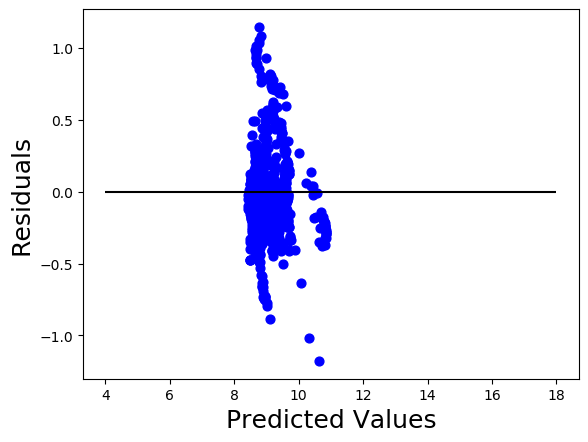

In [59]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. For each example, the residual value
# is the subtraction between the prediction and ground truth target.
# We can see that the points in the residual plot are randomly dispersed around the horizontal axis y = 0,
# which indicates the fitted regression model is appropriate for the ABALONE data

residuals = ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=0, xmin=4, xmax=18)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Residuals", fontsize=18)
plt.show()


In [60]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)


Evaluation result on test data:
r2_score: 0.721307231743318
mean_squared_error: 0.08313233403998127
mean_absolute_error: 0.21150505945217787



In [61]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()